# Federated Learning Test

This notebook is a test of federated learning using the MNIST dataset. It distributes partial subsets of the MNIST data to each worker and tests the results of federation of the workers. It also skews the subsets to investigate the value of federation in cases where workers have substantially different samples.

In [1]:
# Put this in this file to have imported models reload automatically when you edit them.
!cat ~/.ipython/profile_default/startup/00-autoreload.ipy

%load_ext autoreload
%autoreload 2

In [2]:
# Define the model

import torch.nn as nn

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def name(self):
        return "MLP"

In [3]:
# Load the data
data_path = './MNIST-data/raw'

# location of data and labels
test_labels_file = data_path + '/' + 't10k-labels-idx1-ubyte'
test_data_file = data_path + '/' + 't10k-images-idx3-ubyte'
train_labels_file = data_path + '/' + 'train-labels-idx1-ubyte'
train_data_file = data_path + '/' + 'train-images-idx3-ubyte'

In [4]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [5]:
# create standard datasets using all of the MNIST data

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_dset = dsets.MNIST(root=data_path, download=True, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=True, train=False, transform=trans)

In [6]:
from torch.utils.data import WeightedRandomSampler

In [7]:
def stacked_dset(dset, label_weights, N):
    """
    dset: dataset
    label_weights = {dog: 0.5, cat: 0.3, ...}
    N: size of stacked dset
    return: stacked WeightedRandomSampler
    """
    weights = []
    for data, label in dset:
        weights.append(label_weights[label])
    return WeightedRandomSampler(weights, N, replacement=False)

In [8]:
def skewed_weights(num_labels, labels_to_preserve, skew_bias):
    """
        num_labels: number of labels to return (use 10 for MNIST)
        labels_to_preserve: list of labels to preserve wih no skew 
        skew_bias: a float, 0 < bias < 1, to which non-selected labels will be biased down
        return: dictionary of each label and its bias
    """
    weights = {}
    for label in range(num_labels):
        if label in labels_to_preserve:
            weights[label] = 1
        else:
            weights[label] = skew_bias
    
    return weights

In [9]:
from torch.utils.data import DataLoader

In [10]:
# create standard dataloaders using all of the MNIST data

batch_size = 16

train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
test_dloader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

In [11]:
from tqdm import tqdm

In [12]:
loader_size = 4096

stacked_data_loaders = []
for label in tqdm(range(10)):
    #print(label)
    stacked_sampler = stacked_dset(train_dset, skewed_weights(10, [label], 0.4), loader_size)
    stacked_data_loaders.append(DataLoader(train_dset, batch_size=batch_size, shuffle=False, sampler=stacked_sampler))

100%|██████████| 10/10 [01:08<00:00,  6.78s/it]


In [13]:
import federated

learning_rate = 1e-2
num_epochs = 2
num_rounds = 29

#datasets = [train_dloader,
#            train_dloader,
#            train_dloader,            
#            ]

datasets = stacked_data_loaders

manager = federated.FederatedManager(
    datasets,
    MLPNet(),
    nn.CrossEntropyLoss(),
    learning_rate,
    test_dset,
    num_epochs
)

In [14]:
print("Training", num_rounds, "round(s) with", manager.n_workers, "worker(s) doing", num_epochs, "epoch(s) each" )

for i in tqdm(range(num_rounds)):
    print("Beginning round", i)
    manager.round()
    print("    Round: %03d" % i, "Loss: %.5f" % manager.manager_loss_history[-1])

  0%|          | 0/29 [00:00<?, ?it/s]

Training 29 round(s) with 10 worker(s) doing 2 epoch(s) each
Beginning round 0
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 2.3295
        Worker: 488 Batch: 100 Loss: 2.0735
        Worker: 488 Batch: 200 Loss: 2.0817
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 1.3919
        Worker: 488 Batch: 100 Loss: 1.8028
        Worker: 488 Batch: 200 Loss: 1.3146
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 1.3703
        Worker: 408 Batch: 100 Loss: 1.1917
        Worker: 408 Batch: 200 Loss: 0.8174
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 1.0368
        Worker: 408 Batch: 100 Loss: 0.6462
        Worker: 408 Batch: 200 Loss: 0.7853
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 1.1137
        Worker: 744 Batch: 100 Loss: 0.5441
        Worker: 744 Batch: 200 Loss: 0.7718
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.5327
        Worker: 744 Batch: 100 Loss: 0.5162
        Worker: 7

  3%|▎         | 1/29 [02:25<1:07:45, 145.19s/it]

    Round: 000 Loss: 0.32810
Beginning round 1
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.0650
        Worker: 488 Batch: 100 Loss: 0.6573
        Worker: 488 Batch: 200 Loss: 0.1788
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.4415
        Worker: 488 Batch: 100 Loss: 0.4932
        Worker: 488 Batch: 200 Loss: 0.1572
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.2730
        Worker: 408 Batch: 100 Loss: 0.8030
        Worker: 408 Batch: 200 Loss: 0.5401
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.2172
        Worker: 408 Batch: 100 Loss: 0.4671
        Worker: 408 Batch: 200 Loss: 0.0464
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.0718
        Worker: 744 Batch: 100 Loss: 0.1608
        Worker: 744 Batch: 200 Loss: 0.2377
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.1688
        Worker: 744 Batch: 100 Loss: 0.2551
        Worker: 744 Batch: 200 Loss: 0.1471
    W

  7%|▋         | 2/29 [04:48<1:05:02, 144.53s/it]

    Round: 001 Loss: 0.21217
Beginning round 2
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.4802
        Worker: 488 Batch: 100 Loss: 0.8484
        Worker: 488 Batch: 200 Loss: 0.1792
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.7160
        Worker: 488 Batch: 100 Loss: 0.1921
        Worker: 488 Batch: 200 Loss: 0.0843
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.1798
        Worker: 408 Batch: 100 Loss: 0.0776
        Worker: 408 Batch: 200 Loss: 0.2220
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.0803
        Worker: 408 Batch: 100 Loss: 0.2140
        Worker: 408 Batch: 200 Loss: 0.0692
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.1066
        Worker: 744 Batch: 100 Loss: 0.3169
        Worker: 744 Batch: 200 Loss: 0.2179
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.1215
        Worker: 744 Batch: 100 Loss: 0.3784
        Worker: 744 Batch: 200 Loss: 0.0495
    W

 10%|█         | 3/29 [07:10<1:02:18, 143.77s/it]

    Round: 002 Loss: 0.16903
Beginning round 3
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.3999
        Worker: 488 Batch: 100 Loss: 0.1319
        Worker: 488 Batch: 200 Loss: 0.0178
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.3999
        Worker: 488 Batch: 100 Loss: 0.1438
        Worker: 488 Batch: 200 Loss: 0.0423
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.0167
        Worker: 408 Batch: 100 Loss: 0.3411
        Worker: 408 Batch: 200 Loss: 0.0208
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.2441
        Worker: 408 Batch: 100 Loss: 0.5178
        Worker: 408 Batch: 200 Loss: 0.1238
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.0199
        Worker: 744 Batch: 100 Loss: 0.0435
        Worker: 744 Batch: 200 Loss: 0.1774
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.4079
        Worker: 744 Batch: 100 Loss: 0.1210
        Worker: 744 Batch: 200 Loss: 0.2048
    W

 14%|█▍        | 4/29 [09:33<59:52, 143.70s/it]  

    Round: 003 Loss: 0.13874
Beginning round 4
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.0270
        Worker: 488 Batch: 100 Loss: 0.0220
        Worker: 488 Batch: 200 Loss: 0.1251
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.0084
        Worker: 488 Batch: 100 Loss: 0.1601
        Worker: 488 Batch: 200 Loss: 0.0223
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.0224
        Worker: 408 Batch: 100 Loss: 0.0849
        Worker: 408 Batch: 200 Loss: 0.1064
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.0110
        Worker: 408 Batch: 100 Loss: 0.0336
        Worker: 408 Batch: 200 Loss: 0.0096
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.0431
        Worker: 744 Batch: 100 Loss: 0.0075
        Worker: 744 Batch: 200 Loss: 0.0190
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.2702
        Worker: 744 Batch: 100 Loss: 0.4323
        Worker: 744 Batch: 200 Loss: 0.1360
    W

 17%|█▋        | 5/29 [11:53<57:01, 142.57s/it]

    Round: 004 Loss: 0.11851
Beginning round 5
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.0130
        Worker: 488 Batch: 100 Loss: 0.2032
        Worker: 488 Batch: 200 Loss: 0.2494
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.1507
        Worker: 488 Batch: 100 Loss: 0.0108
        Worker: 488 Batch: 200 Loss: 0.0304
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.0207
        Worker: 408 Batch: 100 Loss: 0.0249
        Worker: 408 Batch: 200 Loss: 0.0196
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.0497
        Worker: 408 Batch: 100 Loss: 0.0654
        Worker: 408 Batch: 200 Loss: 0.1228
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.0786
        Worker: 744 Batch: 100 Loss: 0.0923
        Worker: 744 Batch: 200 Loss: 0.1291
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.6221
        Worker: 744 Batch: 100 Loss: 0.0362
        Worker: 744 Batch: 200 Loss: 0.0510
    W

 21%|██        | 6/29 [14:07<53:40, 140.02s/it]

    Round: 005 Loss: 0.10185
Beginning round 6
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.0356
        Worker: 488 Batch: 100 Loss: 0.0274
        Worker: 488 Batch: 200 Loss: 0.0355
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.1144
        Worker: 488 Batch: 100 Loss: 0.0337
        Worker: 488 Batch: 200 Loss: 0.0606
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.0938
        Worker: 408 Batch: 100 Loss: 0.0810
        Worker: 408 Batch: 200 Loss: 0.0084
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.0370
        Worker: 408 Batch: 100 Loss: 0.2895
        Worker: 408 Batch: 200 Loss: 0.0343
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.1207
        Worker: 744 Batch: 100 Loss: 0.0344
        Worker: 744 Batch: 200 Loss: 0.0855
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.0263
        Worker: 744 Batch: 100 Loss: 0.0198
        Worker: 744 Batch: 200 Loss: 0.0501
    W

 24%|██▍       | 7/29 [16:22<50:46, 138.46s/it]

    Round: 006 Loss: 0.09614
Beginning round 7
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.0411
        Worker: 488 Batch: 100 Loss: 0.0066
        Worker: 488 Batch: 200 Loss: 0.0067
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.0190
        Worker: 488 Batch: 100 Loss: 0.1660
        Worker: 488 Batch: 200 Loss: 0.0812
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.0073
        Worker: 408 Batch: 100 Loss: 0.0525
        Worker: 408 Batch: 200 Loss: 0.0203
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.2424
        Worker: 408 Batch: 100 Loss: 0.0087
        Worker: 408 Batch: 200 Loss: 0.0441
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.3471
        Worker: 744 Batch: 100 Loss: 0.0259
        Worker: 744 Batch: 200 Loss: 0.0458
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.0148
        Worker: 744 Batch: 100 Loss: 0.0328
        Worker: 744 Batch: 200 Loss: 0.1942
    W

 28%|██▊       | 8/29 [18:37<48:02, 137.28s/it]

    Round: 007 Loss: 0.08610
Beginning round 8
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.0026
        Worker: 488 Batch: 100 Loss: 0.0111
        Worker: 488 Batch: 200 Loss: 0.1198
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.0126
        Worker: 488 Batch: 100 Loss: 0.1293
        Worker: 488 Batch: 200 Loss: 0.3019
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.0073
        Worker: 408 Batch: 100 Loss: 0.3746
        Worker: 408 Batch: 200 Loss: 0.1544
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.0277
        Worker: 408 Batch: 100 Loss: 0.2409
        Worker: 408 Batch: 200 Loss: 0.0111
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.0165
        Worker: 744 Batch: 100 Loss: 0.0279
        Worker: 744 Batch: 200 Loss: 0.0325
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.1474
        Worker: 744 Batch: 100 Loss: 0.4277
        Worker: 744 Batch: 200 Loss: 0.0078
    W

 31%|███       | 9/29 [20:51<45:26, 136.34s/it]

    Round: 008 Loss: 0.08649
Beginning round 9
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.0101
        Worker: 488 Batch: 100 Loss: 0.0277
        Worker: 488 Batch: 200 Loss: 0.1832
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.0132
        Worker: 488 Batch: 100 Loss: 0.0211
        Worker: 488 Batch: 200 Loss: 0.1213
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.0084
        Worker: 408 Batch: 100 Loss: 0.0078
        Worker: 408 Batch: 200 Loss: 0.2061
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.0127
        Worker: 408 Batch: 100 Loss: 0.0230
        Worker: 408 Batch: 200 Loss: 0.0858
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.3751
        Worker: 744 Batch: 100 Loss: 0.0519
        Worker: 744 Batch: 200 Loss: 0.0150
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.0209
        Worker: 744 Batch: 100 Loss: 0.0408
        Worker: 744 Batch: 200 Loss: 0.0129
    W

 34%|███▍      | 10/29 [23:06<43:04, 136.05s/it]

    Round: 009 Loss: 0.07581
Beginning round 10
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.2250
        Worker: 488 Batch: 100 Loss: 0.0524
        Worker: 488 Batch: 200 Loss: 0.0125
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.0033
        Worker: 488 Batch: 100 Loss: 0.0436
        Worker: 488 Batch: 200 Loss: 0.0042
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.0207
        Worker: 408 Batch: 100 Loss: 0.0215
        Worker: 408 Batch: 200 Loss: 0.0256
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.0087
        Worker: 408 Batch: 100 Loss: 0.0177
        Worker: 408 Batch: 200 Loss: 0.0024
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.0053
        Worker: 744 Batch: 100 Loss: 0.0300
        Worker: 744 Batch: 200 Loss: 0.0702
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.0059
        Worker: 744 Batch: 100 Loss: 0.0126
        Worker: 744 Batch: 200 Loss: 0.0029
    

 38%|███▊      | 11/29 [25:21<40:42, 135.69s/it]

    Round: 010 Loss: 0.08942
Beginning round 11
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.0261
        Worker: 488 Batch: 100 Loss: 0.0410
        Worker: 488 Batch: 200 Loss: 0.0173
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.0075
        Worker: 488 Batch: 100 Loss: 0.0020
        Worker: 488 Batch: 200 Loss: 0.0023
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.0338
        Worker: 408 Batch: 100 Loss: 0.0199
        Worker: 408 Batch: 200 Loss: 0.0160
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.0151
        Worker: 408 Batch: 100 Loss: 0.0581
        Worker: 408 Batch: 200 Loss: 0.0079
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.0386
        Worker: 744 Batch: 100 Loss: 0.1119
        Worker: 744 Batch: 200 Loss: 0.0384
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.0295
        Worker: 744 Batch: 100 Loss: 0.0029
        Worker: 744 Batch: 200 Loss: 0.0351
    

 41%|████▏     | 12/29 [27:36<38:21, 135.35s/it]

    Round: 011 Loss: 0.07197
Beginning round 12
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.0035
        Worker: 488 Batch: 100 Loss: 0.0069
        Worker: 488 Batch: 200 Loss: 0.0145
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.0184
        Worker: 488 Batch: 100 Loss: 0.0104
        Worker: 488 Batch: 200 Loss: 0.0083
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.0074
        Worker: 408 Batch: 100 Loss: 0.0067
        Worker: 408 Batch: 200 Loss: 0.0017
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.0097
        Worker: 408 Batch: 100 Loss: 0.0155
        Worker: 408 Batch: 200 Loss: 0.0439
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.0041
        Worker: 744 Batch: 100 Loss: 0.0591
        Worker: 744 Batch: 200 Loss: 0.0515
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.0453
        Worker: 744 Batch: 100 Loss: 0.0651
        Worker: 744 Batch: 200 Loss: 0.0705
    

 45%|████▍     | 13/29 [29:50<36:02, 135.15s/it]

    Round: 012 Loss: 0.07195
Beginning round 13
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.0069
        Worker: 488 Batch: 100 Loss: 0.0006
        Worker: 488 Batch: 200 Loss: 0.2189
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.0587
        Worker: 488 Batch: 100 Loss: 0.0088
        Worker: 488 Batch: 200 Loss: 0.0044
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.0078
        Worker: 408 Batch: 100 Loss: 0.0048
        Worker: 408 Batch: 200 Loss: 0.0035
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.0382
        Worker: 408 Batch: 100 Loss: 0.0015
        Worker: 408 Batch: 200 Loss: 0.0170
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.0009
        Worker: 744 Batch: 100 Loss: 0.0660
        Worker: 744 Batch: 200 Loss: 0.1159
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.0483
        Worker: 744 Batch: 100 Loss: 0.0243
        Worker: 744 Batch: 200 Loss: 0.0124
    

 48%|████▊     | 14/29 [32:04<33:41, 134.75s/it]

    Round: 013 Loss: 0.07501
Beginning round 14
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.0100
        Worker: 488 Batch: 100 Loss: 0.0049
        Worker: 488 Batch: 200 Loss: 0.0087
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.0135
        Worker: 488 Batch: 100 Loss: 0.0011
        Worker: 488 Batch: 200 Loss: 0.0076
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.1363
        Worker: 408 Batch: 100 Loss: 0.0107
        Worker: 408 Batch: 200 Loss: 0.0241
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.0004
        Worker: 408 Batch: 100 Loss: 0.0005
        Worker: 408 Batch: 200 Loss: 0.0057
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.0428
        Worker: 744 Batch: 100 Loss: 0.0042
        Worker: 744 Batch: 200 Loss: 0.0175
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.0884
        Worker: 744 Batch: 100 Loss: 0.0362
        Worker: 744 Batch: 200 Loss: 0.0349
    

 52%|█████▏    | 15/29 [34:18<31:24, 134.62s/it]

    Round: 014 Loss: 0.06590
Beginning round 15
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.0044
        Worker: 488 Batch: 100 Loss: 0.0362
        Worker: 488 Batch: 200 Loss: 0.0122
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.0046
        Worker: 488 Batch: 100 Loss: 0.0040
        Worker: 488 Batch: 200 Loss: 0.0409
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.0011
        Worker: 408 Batch: 100 Loss: 0.0063
        Worker: 408 Batch: 200 Loss: 0.0906
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.0299
        Worker: 408 Batch: 100 Loss: 0.0196
        Worker: 408 Batch: 200 Loss: 0.0038
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.0002
        Worker: 744 Batch: 100 Loss: 0.0027
        Worker: 744 Batch: 200 Loss: 0.0497
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.0019
        Worker: 744 Batch: 100 Loss: 0.1488
        Worker: 744 Batch: 200 Loss: 0.0463
    

 55%|█████▌    | 16/29 [36:33<29:10, 134.64s/it]

    Round: 015 Loss: 0.06789
Beginning round 16
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.0011
        Worker: 488 Batch: 100 Loss: 0.0089
        Worker: 488 Batch: 200 Loss: 0.0120
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.0015
        Worker: 488 Batch: 100 Loss: 0.0052
        Worker: 488 Batch: 200 Loss: 0.0010
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.0019
        Worker: 408 Batch: 100 Loss: 0.0028
        Worker: 408 Batch: 200 Loss: 0.0193
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.0261
        Worker: 408 Batch: 100 Loss: 0.0026
        Worker: 408 Batch: 200 Loss: 0.0221
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.0042
        Worker: 744 Batch: 100 Loss: 0.0331
        Worker: 744 Batch: 200 Loss: 0.0069
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.0132
        Worker: 744 Batch: 100 Loss: 0.0022
        Worker: 744 Batch: 200 Loss: 0.0011
    

 59%|█████▊    | 17/29 [38:48<26:56, 134.73s/it]

    Round: 016 Loss: 0.06852
Beginning round 17
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.0068
        Worker: 488 Batch: 100 Loss: 0.0451
        Worker: 488 Batch: 200 Loss: 0.0181
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.0036
        Worker: 488 Batch: 100 Loss: 0.0024
        Worker: 488 Batch: 200 Loss: 0.0203
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.0009
        Worker: 408 Batch: 100 Loss: 0.0724
        Worker: 408 Batch: 200 Loss: 0.0053
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.0040
        Worker: 408 Batch: 100 Loss: 0.0308
        Worker: 408 Batch: 200 Loss: 0.0337
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.0985
        Worker: 744 Batch: 100 Loss: 0.0120
        Worker: 744 Batch: 200 Loss: 0.0021
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.0055
        Worker: 744 Batch: 100 Loss: 0.0031
        Worker: 744 Batch: 200 Loss: 0.0039
    

 62%|██████▏   | 18/29 [41:03<24:41, 134.68s/it]

    Round: 017 Loss: 0.07793
Beginning round 18
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.0053
        Worker: 488 Batch: 100 Loss: 0.0007
        Worker: 488 Batch: 200 Loss: 0.0156
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.0026
        Worker: 488 Batch: 100 Loss: 0.0024
        Worker: 488 Batch: 200 Loss: 0.0074
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.0031
        Worker: 408 Batch: 100 Loss: 0.0019
        Worker: 408 Batch: 200 Loss: 0.0004
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.0058
        Worker: 408 Batch: 100 Loss: 0.0098
        Worker: 408 Batch: 200 Loss: 0.0026
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.0022
        Worker: 744 Batch: 100 Loss: 0.0063
        Worker: 744 Batch: 200 Loss: 0.0059
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.0012
        Worker: 744 Batch: 100 Loss: 0.0016
        Worker: 744 Batch: 200 Loss: 0.0020
    

 66%|██████▌   | 19/29 [43:17<22:26, 134.65s/it]

    Round: 018 Loss: 0.06665
Beginning round 19
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.0590
        Worker: 488 Batch: 100 Loss: 0.0087
        Worker: 488 Batch: 200 Loss: 0.0084
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.0150
        Worker: 488 Batch: 100 Loss: 0.0695
        Worker: 488 Batch: 200 Loss: 0.0079
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.0057
        Worker: 408 Batch: 100 Loss: 0.0079
        Worker: 408 Batch: 200 Loss: 0.0042
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.0013
        Worker: 408 Batch: 100 Loss: 0.0003
        Worker: 408 Batch: 200 Loss: 0.0302
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.0189
        Worker: 744 Batch: 100 Loss: 0.0045
        Worker: 744 Batch: 200 Loss: 0.0028
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.0021
        Worker: 744 Batch: 100 Loss: 0.0005
        Worker: 744 Batch: 200 Loss: 0.0025
    

 69%|██████▉   | 20/29 [45:31<20:11, 134.58s/it]

    Round: 019 Loss: 0.06732
Beginning round 20
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.0459
        Worker: 488 Batch: 100 Loss: 0.0003
        Worker: 488 Batch: 200 Loss: 0.0076
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.0046
        Worker: 488 Batch: 100 Loss: 0.0019
        Worker: 488 Batch: 200 Loss: 0.0176
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.0246
        Worker: 408 Batch: 100 Loss: 0.0049
        Worker: 408 Batch: 200 Loss: 0.0482
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.0411
        Worker: 408 Batch: 100 Loss: 0.0047
        Worker: 408 Batch: 200 Loss: 0.0035
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.0199
        Worker: 744 Batch: 100 Loss: 0.0010
        Worker: 744 Batch: 200 Loss: 0.0002
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.0331
        Worker: 744 Batch: 100 Loss: 0.0022
        Worker: 744 Batch: 200 Loss: 0.0005
    

 72%|███████▏  | 21/29 [47:46<17:55, 134.44s/it]

    Round: 020 Loss: 0.06609
Beginning round 21
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.0022
        Worker: 488 Batch: 100 Loss: 0.0034
        Worker: 488 Batch: 200 Loss: 0.0347
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.1189
        Worker: 488 Batch: 100 Loss: 0.0018
        Worker: 488 Batch: 200 Loss: 0.0023
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.0045
        Worker: 408 Batch: 100 Loss: 0.0006
        Worker: 408 Batch: 200 Loss: 0.0022
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.0004
        Worker: 408 Batch: 100 Loss: 0.0019
        Worker: 408 Batch: 200 Loss: 0.0012
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.2704
        Worker: 744 Batch: 100 Loss: 0.0039
        Worker: 744 Batch: 200 Loss: 0.0005
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.0001
        Worker: 744 Batch: 100 Loss: 0.0042
        Worker: 744 Batch: 200 Loss: 0.0008
    

 76%|███████▌  | 22/29 [50:00<15:41, 134.52s/it]

    Round: 021 Loss: 0.06917
Beginning round 22
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.0048
        Worker: 488 Batch: 100 Loss: 0.0040
        Worker: 488 Batch: 200 Loss: 0.0007
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.0026
        Worker: 488 Batch: 100 Loss: 0.0176
        Worker: 488 Batch: 200 Loss: 0.0006
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.0011
        Worker: 408 Batch: 100 Loss: 0.0002
        Worker: 408 Batch: 200 Loss: 0.0016
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.0020
        Worker: 408 Batch: 100 Loss: 0.0043
        Worker: 408 Batch: 200 Loss: 0.0188
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.0066
        Worker: 744 Batch: 100 Loss: 0.0057
        Worker: 744 Batch: 200 Loss: 0.0005
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.0012
        Worker: 744 Batch: 100 Loss: 0.0002
        Worker: 744 Batch: 200 Loss: 0.0082
    

 79%|███████▉  | 23/29 [52:16<13:29, 134.94s/it]

    Round: 022 Loss: 0.06652
Beginning round 23
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.0006
        Worker: 488 Batch: 100 Loss: 0.0182
        Worker: 488 Batch: 200 Loss: 0.0036
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.0051
        Worker: 488 Batch: 100 Loss: 0.0012
        Worker: 488 Batch: 200 Loss: 0.0114
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.0202
        Worker: 408 Batch: 100 Loss: 0.0013
        Worker: 408 Batch: 200 Loss: 0.0019
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.0003
        Worker: 408 Batch: 100 Loss: 0.0032
        Worker: 408 Batch: 200 Loss: 0.0047
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.0024
        Worker: 744 Batch: 100 Loss: 0.0328
        Worker: 744 Batch: 200 Loss: 0.0012
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.0147
        Worker: 744 Batch: 100 Loss: 0.0012
        Worker: 744 Batch: 200 Loss: 0.0105
    

 83%|████████▎ | 24/29 [54:31<11:14, 134.95s/it]

    Round: 023 Loss: 0.06862
Beginning round 24
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.0010
        Worker: 488 Batch: 100 Loss: 0.0039
        Worker: 488 Batch: 200 Loss: 0.0016
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.0046
        Worker: 488 Batch: 100 Loss: 0.0013
        Worker: 488 Batch: 200 Loss: 0.0004
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.0005
        Worker: 408 Batch: 100 Loss: 0.0014
        Worker: 408 Batch: 200 Loss: 0.0109
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.0003
        Worker: 408 Batch: 100 Loss: 0.0743
        Worker: 408 Batch: 200 Loss: 0.0085
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.0025
        Worker: 744 Batch: 100 Loss: 0.0035
        Worker: 744 Batch: 200 Loss: 0.0283
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.0074
        Worker: 744 Batch: 100 Loss: 0.0040
        Worker: 744 Batch: 200 Loss: 0.0011
    

 86%|████████▌ | 25/29 [56:46<08:59, 134.86s/it]

    Round: 024 Loss: 0.06679
Beginning round 25
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.0067
        Worker: 488 Batch: 100 Loss: 0.0204
        Worker: 488 Batch: 200 Loss: 0.0213
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.0000
        Worker: 488 Batch: 100 Loss: 0.0010
        Worker: 488 Batch: 200 Loss: 0.0001
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.0021
        Worker: 408 Batch: 100 Loss: 0.0006
        Worker: 408 Batch: 200 Loss: 0.0148
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.0000
        Worker: 408 Batch: 100 Loss: 0.0023
        Worker: 408 Batch: 200 Loss: 0.0193
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.0158
        Worker: 744 Batch: 100 Loss: 0.0077
        Worker: 744 Batch: 200 Loss: 0.0001
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.0027
        Worker: 744 Batch: 100 Loss: 0.0179
        Worker: 744 Batch: 200 Loss: 0.0032
    

 90%|████████▉ | 26/29 [59:00<06:44, 134.72s/it]

    Round: 025 Loss: 0.06545
Beginning round 26
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.0136
        Worker: 488 Batch: 100 Loss: 0.0002
        Worker: 488 Batch: 200 Loss: 0.0005
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.0024
        Worker: 488 Batch: 100 Loss: 0.0148
        Worker: 488 Batch: 200 Loss: 0.0094
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.0015
        Worker: 408 Batch: 100 Loss: 0.0003
        Worker: 408 Batch: 200 Loss: 0.0032
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.0002
        Worker: 408 Batch: 100 Loss: 0.0012
        Worker: 408 Batch: 200 Loss: 0.0389
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.0003
        Worker: 744 Batch: 100 Loss: 0.0019
        Worker: 744 Batch: 200 Loss: 0.0037
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.0061
        Worker: 744 Batch: 100 Loss: 0.0004
        Worker: 744 Batch: 200 Loss: 0.0022
    

 93%|█████████▎| 27/29 [1:01:15<04:29, 134.66s/it]

    Round: 026 Loss: 0.06816
Beginning round 27
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.0020
        Worker: 488 Batch: 100 Loss: 0.0033
        Worker: 488 Batch: 200 Loss: 0.0189
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.0125
        Worker: 488 Batch: 100 Loss: 0.0140
        Worker: 488 Batch: 200 Loss: 0.0138
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.0008
        Worker: 408 Batch: 100 Loss: 0.0002
        Worker: 408 Batch: 200 Loss: 0.0011
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.0262
        Worker: 408 Batch: 100 Loss: 0.0282
        Worker: 408 Batch: 200 Loss: 0.0016
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.0008
        Worker: 744 Batch: 100 Loss: 0.0072
        Worker: 744 Batch: 200 Loss: 0.0061
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.0056
        Worker: 744 Batch: 100 Loss: 0.0120
        Worker: 744 Batch: 200 Loss: 0.0028
    

 97%|█████████▋| 28/29 [1:03:30<02:14, 134.73s/it]

    Round: 027 Loss: 0.06476
Beginning round 28
    Worker: 488 Epoch:  0
        Worker: 488 Batch: 000 Loss: 0.0026
        Worker: 488 Batch: 100 Loss: 0.0060
        Worker: 488 Batch: 200 Loss: 0.0069
    Worker: 488 Epoch:  1
        Worker: 488 Batch: 000 Loss: 0.0006
        Worker: 488 Batch: 100 Loss: 0.0007
        Worker: 488 Batch: 200 Loss: 0.0001
    Worker: 408 Epoch:  0
        Worker: 408 Batch: 000 Loss: 0.0104
        Worker: 408 Batch: 100 Loss: 0.0031
        Worker: 408 Batch: 200 Loss: 0.0002
    Worker: 408 Epoch:  1
        Worker: 408 Batch: 000 Loss: 0.0052
        Worker: 408 Batch: 100 Loss: 0.0043
        Worker: 408 Batch: 200 Loss: 0.0005
    Worker: 744 Epoch:  0
        Worker: 744 Batch: 000 Loss: 0.0050
        Worker: 744 Batch: 100 Loss: 0.0007
        Worker: 744 Batch: 200 Loss: 0.0033
    Worker: 744 Epoch:  1
        Worker: 744 Batch: 000 Loss: 0.0019
        Worker: 744 Batch: 100 Loss: 0.0004
        Worker: 744 Batch: 200 Loss: 0.0050
    

100%|██████████| 29/29 [1:05:44<00:00, 134.66s/it]

    Round: 028 Loss: 0.06509


10


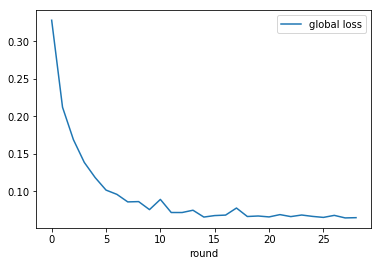

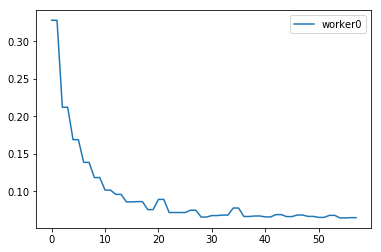

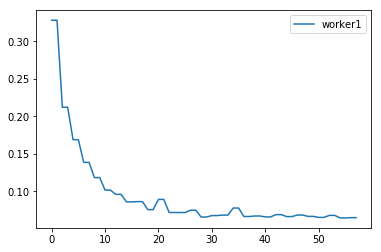

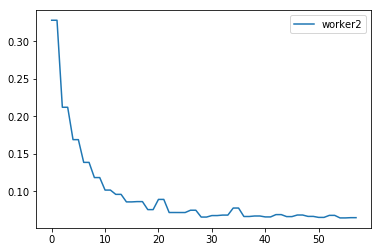

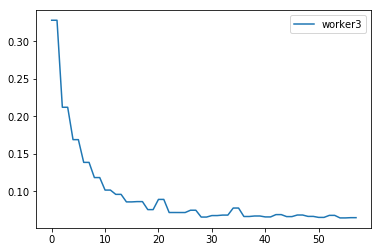

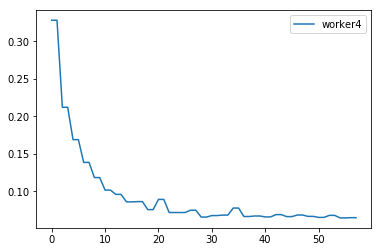

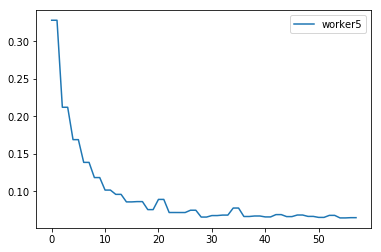

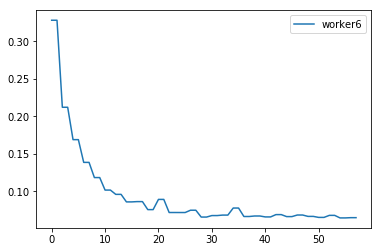

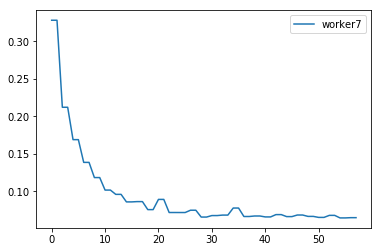

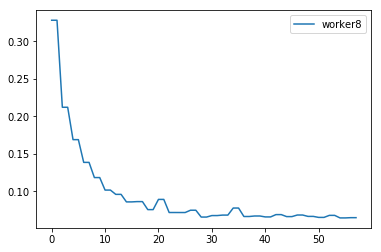

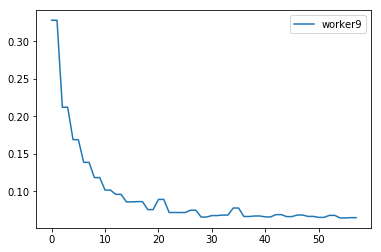

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# loss of global model on test set gets recorded twice per round
# [1::2] skips the record that takes place before that round's training has happened
ax.plot(manager.manager_loss_history[1::2], label="global loss")
ax.set_xlabel("round");
ax.legend();

# fig, ax = plt.subplots(1, 2)
# ax[0].plot(manager.worker_loss_histories[0], label="worker0")
# ax[0].set_xlabel("rounds")
# ax[1].plot(manager.worker_loss_histories[1], label="worker1")
# ax[1].set_xlabel("rounds")
# ax[0].legend()
# ax[1].legend();

#fig, ax = plt.subplots()

print(len(manager.worker_loss_histories))

for i in range(len(manager.worker_loss_histories)):
    
    fig, ax = plt.subplots()
    lbl = "worker" + str(i)
    ax.plot(manager.worker_loss_histories[i], label=lbl)
    ax.legend();

#ax.legend();

#TODO Get the plots correct

In [16]:
## TODO - need to get the stacked decks combined to train a common model with all of them. It's not a fair comparison to have the non-federated approach exposed to the entire MNIST set, while the cumulative federated workers get less.

